# Unit 7 - Module 3: Data Exploration, Visualization & Analysis

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

# Outline

__[3.1] Data Collection and Cleaning__

__[3.2] Heatmaps I - Data Visualization (and dealing with noisy data)__

__[3.3] Heatmaps II - Algorithmic thinking when creating visualizations__

__[3.4] Testing for associations between variables__

__References__

Import necessary packages

In [5]:
import pandas as pd
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gdp
import statsmodels as smd
from shapely.geometry import Point, Polygon
import descartes
from collections import Counter
import matplotlib.cm as cm
import statsmodels.api as sm
from fiona.crs import from_epsg
from math import radians, cos, sin, asin, sqrt
from geopandas import GeoDataFrame

# [3.0] Project Overview

To get some exposure to real world data, we'll start by asking a question that's probably on all of your minds. As I was walking around one day with a cup of coffee from Dunkin' Donuts, I wondered which area of Boston had the highest concentration of Dunkin' Donuts locations. 

We can answer this question and visualize the results with Python! And we will walk through the analysis with a Jupyter notebook.

Here's an overview of the questions we're going to attempt to answer and visualiaztions that we're aiming to create:

**3.2** Which zip code in Boston has the highest concentration of Dunkin' locations adjusted for the number of people living in each zip code? How can we visualize this with a heatmap?

**3.3** How can we create a visualization that will display the distance to the closest Dunkin' location for any given point in a map?

**3.4** Is there a relationship between the concentration of Dunkin' locations in a zip code and the mean household income for that zip code?

The first step is of course acquiring the *data* for the data analysis, so let's begin there!

# [3.1] Data Collection and Cleaning

The first step in undertaking a data analysis project is acquiring and cleaning the data. Below are several CSV (comma seperate value) files that I downloaded from various places (see **References**). Once you have the data, you can use **Pandas** to load the CSV files and clean them.

Though you'll have to scavange the internet for data that's relevent to any projects you choose to undertake, I've included all of the relevent files for this analysis in the same github repository that these notebooks are located in.

##### Dunkin Donuts locations across the United States

This DataFrame below is created from loaded a CSV file of all of the Dunkin' locations across the United States (complete with address & lat/lng coordinates)

In [6]:
DunkinDonuts_DF = pd.read_csv('/home/rv76/RDMLA Course/Module 3 Files/dunkindonuts.csv') #my path to csv file

In [7]:
DunkinDonuts_DF.head()

,id,address,city,state,zip,country,lat,lng
0,300176,1752B Route 9,Clifton Park,NY,12065,US,42.871739,-73.774136
1,300178,99 High St,Danvers,MA,1923,US,42.559575,-70.931239
2,300179,17 Railroad Ave,Rockport,MA,1966,US,42.656344,-70.626211
3,300202,411 Furrows Rd,Holbrook,NY,11741,US,40.806919,-73.072950
4,300204,140 Central Ave,East Orange,NJ,7018,US,40.752378,-74.207983


In [8]:
np.shape(DunkinDonuts_DF)

(7794, 8)

##### Zip Codes of Boston, MA

This DataFrame contains the all of the Zip Codes in Boston 

In [9]:
Zip_Codes_DF = pd.read_csv('/home/rv76/RDMLA Course/Module 3 Files/ZIP_Codes.csv').set_index('OBJECTID')

In [10]:
Zip_Codes_DF.head()

,ZIP5,ShapeSTArea,ShapeSTLength
OBJECTID,,,
1,2134,3.721936e+07,40794.182396
2,2125,6.476052e+07,62224.521440
3,2110,6.637284e+06,18358.213496
4,2118,3.116158e+07,32353.407618
5,2126,6.078585e+07,45488.394711


In [11]:
np.shape(Zip_Codes_DF)

(43, 3)

Since we only care about the Dunkin' locations within Boston proper, we're going to iterate over all of the Dunkin' locations with a loop and check to see if the zipcode for that location is one of the Boston Zip Codes. We'll store a boolean (True / False) value for each location to filter the Dunkin' DataFrame later.

##### Dunkin Donuts locations in Boston Zip Codes

In [12]:
Boston_dunkin_location_filter = []

for dunkin_location_zip in list(DunkinDonuts_DF.zip):
    
    if dunkin_location_zip in list(Zip_Codes_DF.ZIP5):
        
        Boston_dunkin_location_filter.append(True)
        
    else:
        
        Boston_dunkin_location_filter.append(False)

Here we use the boolean filter constructed above to subset the Dunkin' locations across the U.S. to just Dunkin' locations that lie within Boston zip codes.

In [13]:
DunkinDonuts_Boston_DF = DunkinDonuts_DF[Boston_dunkin_location_filter]

In [14]:
DunkinDonuts_Boston_DF.head()

,id,address,city,state,zip,country,lat,lng
5,300205,22 Washington St,Canton,MA,2021,US,42.139105,-71.148928
16,300240,13-15 Maverick Sq,East Boston,MA,2128,US,42.369062,-71.039333
50,300304,395 Providence Hwy,Dedham,MA,2026,US,42.250106,-71.171922
51,300305,214 N. Beacon St,Brighton,MA,2135,US,42.356017,-71.149212
56,300314,875 Morrissey Blvd,Dorchester,MA,2122,US,42.293589,-71.048325


In [15]:
np.shape(DunkinDonuts_Boston_DF)

(150, 8)

Since each row corresponds to a location, it appears that there are 150 Dunkin' locations within Boston zip codes. So here are the DataFrames that we have so far:

1. A DataFrame that contains the locations (addresses & lat/lng coordinates) for all of the Dunkin' locations in Boston
1. A DataFrame that contains the zip codes in Boston proper

Filtering & Cleaning your data is one of the most important steps in Data Analysis & will make any downstream analysis much easier.

# [3.2] Heatmaps I - Data Visualization (and dealing with noisy data)

Often times you'll find weird artifacts in your data (even after you thought you've cleaned it up). So in this next part we'll see that there are still some artifacts in the data that we'll continue to filter out.

The aim here is to answer our first question about the concentration of Dunkin' locations in Boston. We'll create a visualization that shows us the locations of the Dunkin' locations within Boston zip codes & the concentration of Dunkin' within each zip code.

##### Mapping Boston Zip Codes

In order to create a map of Boston zip codes, I've downloaded a the shape files corresponding to the zip codes (the geojson file) that we can load with the **geopandas** package in python.

- Side Note: When creating a visualization of a map, the coordinates can take on difference reference systems. One that reflects the curvature of the Earth but isn't as pleasing visually uses the standard latitude/longitude coordinates (this is the  CRS 4326/*WGS84* projection). Another system called the Mercator projection displays the coordinates in a much more visually appealing way. 

- We can sway back and forth between these two systems easily using **geopandas** since we'll want the any coordinates (for the zip code shape files & Dunkin' locations) in the *WGS84* projection if we're trying to find distances between these coordinates (which we'll do later) but want the coordinates in the *Mercator* projection if we're creating a visual of these objects.

In [16]:
crs = {'init':'epsg:3395'} #have to specify a coordinate reference system (this corresponds to the Mercator project system)

Geopandas DataFrame with the shape files for Boston zip codes.

In [17]:
Boston_ZipCode_geography_df = gdp.read_file("/home/rv76/RDMLA Course/Module 3 Files/ZIP_Codes.geojson").set_index('OBJECTID')

#zip code geojson files are loaded in with CRS 4326 which corresponds to latitude / longitude coordinates, below we project these points onto the Mercator system
Boston_ZipCode_geography_df = Boston_ZipCode_geography_df.to_crs(crs)

In [18]:
Boston_ZipCode_geography_df.head()

,ZIP5,ShapeSTArea,ShapeSTLength,geometry
OBJECTID,,,,
1,02134,3.721936e+07,40794.182396,POLYGON ((-7917421.184931348 5186892.588150488...
2,02125,6.476052e+07,62224.521440,POLYGON ((-7908739.374789597 5180829.878902367...
3,02110,6.637284e+06,18358.213496,"POLYGON ((-7909371.22467089 5186888.835886299,..."
4,02118,3.116158e+07,32353.407618,POLYGON ((-7910713.849317109 5184293.074784211...
5,02126,6.078585e+07,45488.394711,POLYGON ((-7914448.062572259 5175902.410114749...


In [19]:
np.shape(Boston_ZipCode_geography_df)

(43, 4)

Geopandas makes it easy to create a map of the zip codes in Boston!

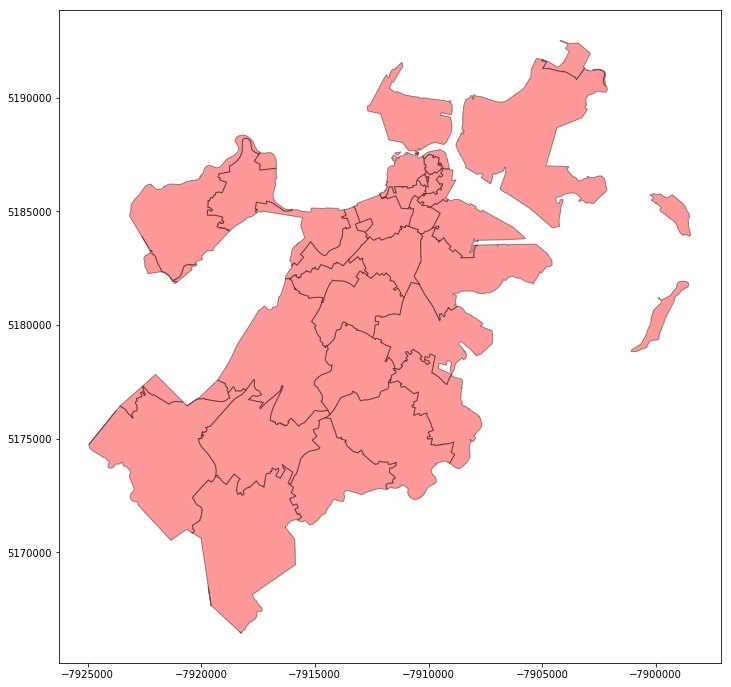

In [20]:
fig , ax = plt.subplots(figsize=(12, 12))

Boston_ZipCode_geography_df.plot(ax = ax, color = 'r' , alpha = 0.4 , edgecolor = 'k')

##### Mapping Boston Dunkin Donuts locations

Now that we have a map of the zip codes in Boston, we want to visualize where all of the Dunkin' locations are within this map. We'll convert the lat/lng coordinates to *POINT* geometry and add this column to our existing DataFrame of Dunkin' locations. Then we'll convert the projection system to the *Mercator* projection to match the same projection that the zip codes are plotted within. 

Pandas DataFrames are easy to manipulate which is one of the reasons they are so useful in data analysis.

In [21]:
#convert lng/lat coordinates of Dunkin' locations to POINT geometry to use for plotting
Boston_dunkin_donuts_locations_points = [Point(x,y) for x,y in zip( DunkinDonuts_Boston_DF['lng'] , DunkinDonuts_Boston_DF['lat'] ) ]

#convert to CRS 4326 (WGS84 - lat/lon) when initializing geopandas df
Boston_dunkin_donuts_locations_geography_df = gdp.GeoDataFrame(DunkinDonuts_Boston_DF , crs = {'init':'epsg:4326'} , geometry = Boston_dunkin_donuts_locations_points)

#project onto Mercator by changing CRS to 3395 (same as zip code shape files)
Boston_dunkin_donuts_locations_geography_df = Boston_dunkin_donuts_locations_geography_df.to_crs(crs)

In [22]:
Boston_dunkin_donuts_locations_geography_df.head()

,id,address,city,state,zip,country,lat,lng,geometry
5,300205,22 Washington St,Canton,MA,2021,US,42.139105,-71.148928,POINT (-7920262.435447284 5153163.427489666)
16,300240,13-15 Maverick Sq,East Boston,MA,2128,US,42.369062,-71.039333,POINT (-7908062.375853796 5187621.140806558)
50,300304,395 Providence Hwy,Dedham,MA,2026,US,42.250106,-71.171922,POINT (-7922822.115818583 5169780.478748407)
51,300305,214 N. Beacon St,Brighton,MA,2135,US,42.356017,-71.149212,POINT (-7920294.050182669 5185663.0317325)
56,300314,875 Morrissey Blvd,Dorchester,MA,2122,US,42.293589,-71.048325,POINT (-7909063.360715008 5176297.990634453)


Once we have a DataFrame with the geometric coordinates of the Dunkin' locations, we can plot both the locations & zip codes on the same map!

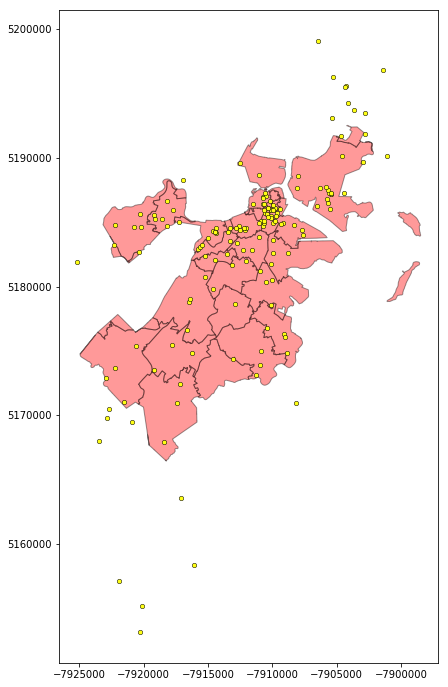

In [23]:
fig , ax = plt.subplots(figsize=(12, 12))

#plot Zip Codes
Boston_ZipCode_geography_df.plot(ax = ax, color = 'r' , alpha = 0.4 , edgecolor = 'k')

#plot Dunkin Donuts Locations
Boston_dunkin_donuts_locations_geography_df.plot(ax = ax, markersize = 20, color = 'xkcd:yellow' , marker = "o" , edgecolor = 'k' , linewidth = 0.5)


Okay so something seems off, why are there Dunkin' locations that lie outside of Boston proper? Looks like we've unocvered some noise in our data that we have to clean. Often times you'll have to inspect the raw data (CSV files) to see where things may have gone wrong. 

After going through the files and creating various plots, the problem can be decomposed into two seperate problems:

1. Zip Codes were included that weren't part of Boston proper, which messed with our filter to include only Dunkin' locations in Boston proper

1. some of the shape files were innaccurately included as part of Boston proper. 

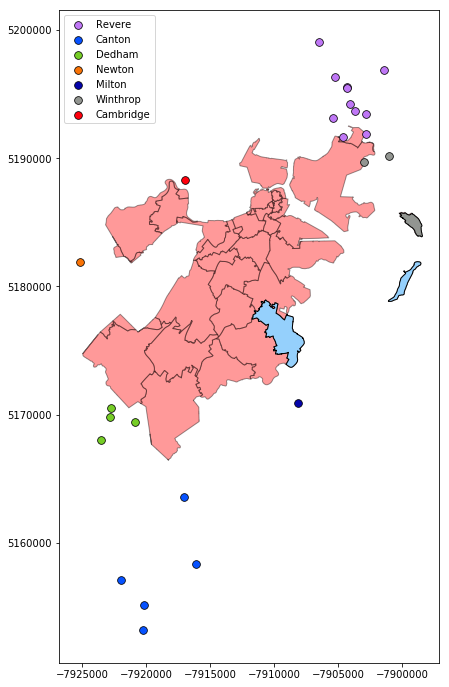

In [24]:
fig , ax = plt.subplots(figsize=(12, 12))

#plot Zip Codes
Boston_ZipCode_geography_df.plot(ax = ax, color = 'r' , alpha = 0.4 , edgecolor = 'k')

#plot Dunkin Donuts locations that aren't located in Boston proper
rev_loc = Boston_dunkin_donuts_locations_geography_df[Boston_dunkin_donuts_locations_geography_df.city == 'Revere'].plot(ax = ax, markersize = 60, color = 'xkcd:light purple' , marker = "o" , edgecolor = 'k' , linewidth = 0.75 , label = 'Revere')
can_loc = Boston_dunkin_donuts_locations_geography_df[Boston_dunkin_donuts_locations_geography_df.city == 'Canton'].plot(ax = ax, markersize = 60, color = 'xkcd:electric blue' , marker = "o" , edgecolor = 'k' , linewidth = 0.75 , label = 'Canton')
ded_loc = Boston_dunkin_donuts_locations_geography_df[Boston_dunkin_donuts_locations_geography_df.city == 'Dedham'].plot(ax = ax, markersize = 60, color = 'xkcd:apple green' , marker = "o" , edgecolor = 'k' , linewidth = 0.75 , label = 'Dedham')
new_loc = Boston_dunkin_donuts_locations_geography_df[Boston_dunkin_donuts_locations_geography_df.city == 'Newton'].plot(ax = ax, markersize = 60, color = 'xkcd:orange' , marker = "o" , edgecolor = 'k' , linewidth = 0.75 , label = 'Newton')
mil_loc = Boston_dunkin_donuts_locations_geography_df[Boston_dunkin_donuts_locations_geography_df.city == 'Milton'].plot(ax = ax, markersize = 60, color = 'xkcd:royal blue' , marker = "o" , edgecolor = 'k' , linewidth = 0.75 , label = 'Milton')
win_loc = Boston_dunkin_donuts_locations_geography_df[Boston_dunkin_donuts_locations_geography_df.city == 'Winthrop'].plot(ax = ax, markersize = 60, color = 'xkcd:grey' , marker = "o" , edgecolor = 'k' , linewidth = 0.75 , label = 'Winthrop')
cam_loc = Boston_dunkin_donuts_locations_geography_df[Boston_dunkin_donuts_locations_geography_df.city == 'Cambridge'].plot(ax = ax, markersize = 60, color = 'xkcd:bright red' , marker = "o" , edgecolor = 'k' , linewidth = 0.75 , label = 'Cambridge')

#plot 'Long Island' which is part of Quincy and should not be included with Boston & part of Dorchester, the polygon shape for Long Island got classified as part of zip code 02122 which is Dorchester
long_island = Boston_ZipCode_geography_df[Boston_ZipCode_geography_df.ZIP5 == '02122'].plot(ax = ax , color = 'xkcd:light blue' , label = 'Dorchester & Long Island' , edgecolor = 'k')

#plot 'Deer Island' which is part of Winthrop and should not be included with Boston (this is why the two Dunkin' locations from Wintrop were accidentally included)
deer_island = Boston_ZipCode_geography_df[Boston_ZipCode_geography_df.ZIP5 == '02152'].plot(ax = ax , color = 'xkcd:grey' , label = 'Deer Island' , edgecolor = 'k')

#legend
plt.legend()

1. As you can see in the map above, several of the Dunkin' locations that were included belonged to neighborhoods surrounding Boston, but since we're only interested in Boston proper, we're going to drop these for further analysis.

1. Some of the shape files for the zip codes were also erroneous, Deer Island (gray) is part of Winthrop and should not be included so we're going to drop this shapefile and Long Island (light blue) is part of Quincy but it's shape file was accidentally included with Dorchester (which is part of Boston proper) so we'll drop the shape files corresponding to both of these islands.

##### Getting rid of zip codes locations that aren't in Boston Proper & Long Island which was classified as part of Dorchester

Our first pass showed that our Zip Code list contained zip codes from Revere, Canton, Dedham, Newton, Milton, Winthrop & Cambridge. Since we're interested in the Dunkin Donuts concentration for Boston proper, we're going to drop these zip codes (and corresponding locations) from our analysis.

In [25]:
cities_not_part_of_Boston = ['Revere' , 'Canton' , 'Dedham' , 'Newton' , 'Milton' , 'Winthrop' , 'Cambridge']

#list that will store zip codes corresponding to the cities above
zip_codes_not_in_Boston = []

#create a boolean filter to subset our Dunkin Donuts locations DataFrame to locations in Boston Proper
DD_locations_df_zip_codes_in_Boston_filter = []

#iterate across all Dunkin Donuts locations
for zip_code , city in zip(Boston_dunkin_donuts_locations_geography_df.zip , Boston_dunkin_donuts_locations_geography_df.city): 

    #if the city is in the list of cities that are not part of Boston proper
    if city in cities_not_part_of_Boston:
        
        zip_codes_not_in_Boston.append(zip_code)
        DD_locations_df_zip_codes_in_Boston_filter.append(False)
        
    #otherwise city should be in Boston proper
    else:
        DD_locations_df_zip_codes_in_Boston_filter.append(True)
        
#for Zip Codes not in Boston, we can get rid of copies
zip_codes_not_in_Boston = list(set(zip_codes_not_in_Boston))

In [26]:
zip_codes_not_in_Boston

[2021, 2151, 2152, 2026, 2186, 2163, 2459]

Subset our Boston Dunkin Donuts locations goegraphy DataFrame to those locations in Boston Proper

In [27]:
Boston_proper_dunkin_donuts_locations_geography_df = Boston_dunkin_donuts_locations_geography_df[DD_locations_df_zip_codes_in_Boston_filter]

In [28]:
np.shape(Boston_proper_dunkin_donuts_locations_geography_df) #went from 150 locations to 125 locations in Boston, dropped 25 locations not in Boston proper

(125, 9)

In [29]:
Boston_proper_dunkin_donuts_locations_geography_df.head()

,id,address,city,state,zip,country,lat,lng,geometry
16,300240,13-15 Maverick Sq,East Boston,MA,2128,US,42.369062,-71.039333,POINT (-7908062.375853796 5187621.140806558)
51,300305,214 N. Beacon St,Brighton,MA,2135,US,42.356017,-71.149212,POINT (-7920294.050182669 5185663.0317325)
56,300314,875 Morrissey Blvd,Dorchester,MA,2122,US,42.293589,-71.048325,POINT (-7909063.360715008 5176297.990634453)
100,300417,715 Boylston St,Boston,MA,2116,US,42.349561,-71.079929,POINT (-7912581.501902039 5184694.110583656)
200,300660,4175 Washington St,Roslindale,MA,2131,US,42.287906,-71.126892,POINT (-7917809.399148163 5175445.928649778)


Subset our Boston Zip Code geography DataFrame to those Zip Codes in Boston Proper (this drops Deer Island)

In [30]:
Boston_ZipCode_geography_df_zip_codes_in_Boston_filter = [ int(zip_code) not in zip_codes_not_in_Boston for zip_code in Boston_ZipCode_geography_df.ZIP5]
Boston_proper_ZipCode_geography_df = Boston_ZipCode_geography_df[Boston_ZipCode_geography_df_zip_codes_in_Boston_filter]

In [31]:
np.shape(Boston_proper_ZipCode_geography_df) #went from 43 zip codes to 36 zip codes in Boston, dopped the 7 zip codes not in Boston proper

(36, 4)

Change the shape file for zip code 02122 to disclude *Long Island* which is not part of Boston but to keep *Dorchester* which very much is part of Boston

In [32]:
#replace the shape file(s) for zip code 02122 with the single shape file that corresponds to Dorchester, discarding the shape file (Polygon) that respresents Long Island
Boston_proper_ZipCode_geography_df.loc[32 , 'geometry'] = list( Boston_ZipCode_geography_df.loc[32].geometry )[0]

In [33]:
Boston_proper_ZipCode_geography_df.head()

,ZIP5,ShapeSTArea,ShapeSTLength,geometry
OBJECTID,,,,
1,02134,3.721936e+07,40794.182396,POLYGON ((-7917421.184931348 5186892.588150488...
2,02125,6.476052e+07,62224.521440,POLYGON ((-7908739.374789597 5180829.878902367...
3,02110,6.637284e+06,18358.213496,"POLYGON ((-7909371.22467089 5186888.835886299,..."
4,02118,3.116158e+07,32353.407618,POLYGON ((-7910713.849317109 5184293.074784211...
5,02126,6.078585e+07,45488.394711,POLYGON ((-7914448.062572259 5175902.410114749...


Now that we've filtered out the noise from our data, we can visualize what we were after. We have our two imporant DataFrames

1. A DataFrame that contains all of the Dunkin' locations in the Boston proper area (and corresponding POINT geometries)
1. A DataFrame that contains the zip codes for Boston proper (and corresponding SHAPE geometries)

Plotting these on top of each other we get what we were after.

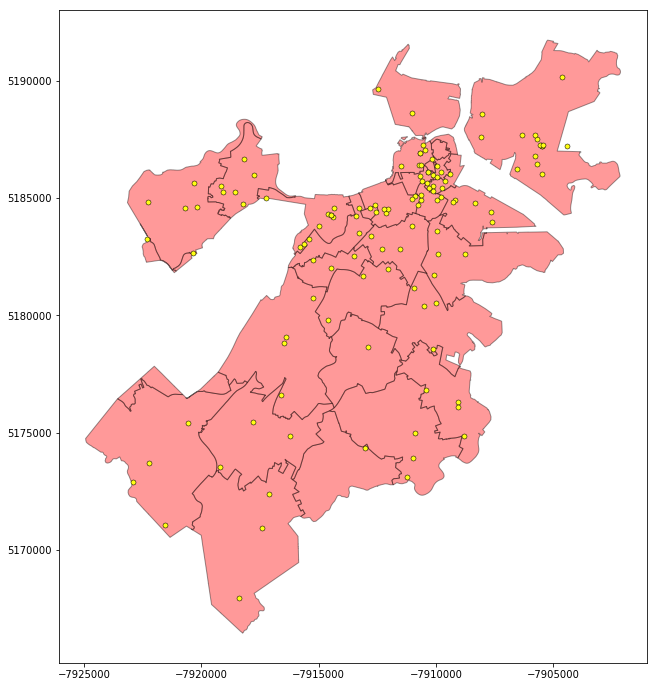

In [34]:
fig , ax = plt.subplots(figsize=(12, 12))

#plot Zip Codes
Boston_proper_ZipCode_geography_df.plot(ax = ax, color = 'r' , alpha = 0.4 , edgecolor = 'k')

#plot Dunkin Donuts Locations
Boston_proper_dunkin_donuts_locations_geography_df.plot(ax = ax, markersize = 25, color = 'xkcd:yellow' , marker = "o" , edgecolor = 'k' , linewidth = 0.5)

##### How many Dunkin Donuts locations are there in each Zip Code?

To continue answering our original question, we can now count the number of Dunkin' locations in each zip code. 

All we have to do for this is iterate over each zip code and ask how many Dunkin' locations are associated with that zip code. We'll create a list storing the number of Dunkin' locations per zip code and append it to our DataFrame of zip codes.

In [35]:
Boston_proper_ZipCode_geography_df.head()

,ZIP5,ShapeSTArea,ShapeSTLength,geometry
OBJECTID,,,,
1,02134,3.721936e+07,40794.182396,POLYGON ((-7917421.184931348 5186892.588150488...
2,02125,6.476052e+07,62224.521440,POLYGON ((-7908739.374789597 5180829.878902367...
3,02110,6.637284e+06,18358.213496,"POLYGON ((-7909371.22467089 5186888.835886299,..."
4,02118,3.116158e+07,32353.407618,POLYGON ((-7910713.849317109 5184293.074784211...
5,02126,6.078585e+07,45488.394711,POLYGON ((-7914448.062572259 5175902.410114749...


In [36]:
#count the number of times each zip code appears in our Dunkin Donuts locations DataFrame
num_DD_locations_per_zip_code = [] 

#iterate through each Zip Code and count number of DD locations
for zip_code in Boston_proper_ZipCode_geography_df.ZIP5:
    
    #creates a boolean list and counts the number of 'True' values
    num_DD_locations_in_zip_code = sum( Boston_proper_dunkin_donuts_locations_geography_df.zip == int(zip_code) )
    
    #store in list
    num_DD_locations_per_zip_code.append(num_DD_locations_in_zip_code)
    
#append as an extra column to our Zip Code geography dataframe
Boston_proper_ZipCode_geography_df['num_DD_locs'] = num_DD_locations_per_zip_code

We now have a column with the number of Dunkin' Donuts locations in each zip code

In [37]:
Boston_proper_ZipCode_geography_df.sort_values(by = 'num_DD_locs' , ascending = False).head()

,ZIP5,ShapeSTArea,ShapeSTLength,geometry,num_DD_locs
OBJECTID,,,,,
31,02128,1.478022e+08,82747.690323,POLYGON ((-7904130.858067364 5191154.981628753...,17
19,02114,1.253863e+07,27934.531421,(POLYGON ((-7910894.739675815 5187585.35218862...,9
29,02215,2.519831e+07,37861.731305,POLYGON ((-7916824.067031224 5185349.452648755...,8
24,02116,1.911765e+07,23262.912273,(POLYGON ((-7912109.90761569 5185671.537587294...,7
1,02134,3.721936e+07,40794.182396,POLYGON ((-7917421.184931348 5186892.588150488...,6


##### Heatmap that illustrates how many Dunkin' Donuts locations are in each zip code

We now have the number of locations for each zip code. We can visualize the number of locations per zip code with a heatmap. 

- This requires some scaling of a matplotlib color map, then plotting each zip code individually with a color that is associated with how many Dunkin' locations can be found within the zip code. 

- Darker colors correspond to more Dunkin' locations within that zip code.

We're going to plot each zip code individually and it's color will scale with how many DD locations there are within the zip code

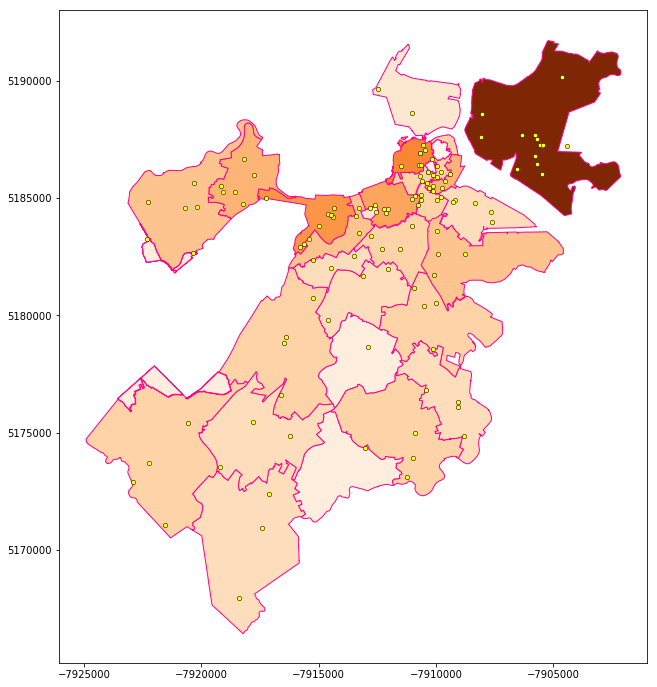

In [38]:
fig , ax = plt.subplots(figsize=(12, 12))

cmap = mpl.cm.get_cmap('Oranges')
norm = mpl.colors.Normalize(vmin = np.min(Boston_proper_ZipCode_geography_df.num_DD_locs) , vmax = np.max(Boston_proper_ZipCode_geography_df.num_DD_locs))

#plot Zip Codes 1-by-1
for zip_code , num_DD_locations in zip( Boston_proper_ZipCode_geography_df.ZIP5 , Boston_proper_ZipCode_geography_df.num_DD_locs ):
    
    Boston_proper_ZipCode_geography_df[Boston_proper_ZipCode_geography_df.ZIP5 == zip_code].plot(ax = ax, color = cmap(norm(num_DD_locations)) , edgecolor = 'xkcd:hot pink')

#plot Dunkin Donuts Locations
Boston_proper_dunkin_donuts_locations_geography_df.plot(ax = ax, markersize = 20, color = 'xkcd:yellow' , marker = "o" , edgecolor = 'k' , linewidth = 0.5)

We have our heatmap that illustrates how many Dunkin' locations are within each zip code! Let's tidy this up a bit by removing the locations, adding a legend and a few other changes makes the figure look a bit cleaner.

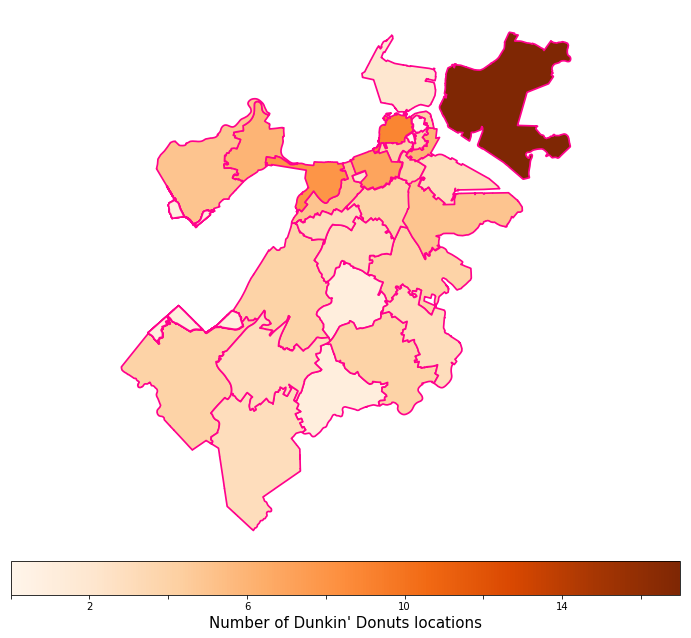

In [39]:
fig , ax = plt.subplots(figsize=(12, 12.0))

cmap = mpl.cm.get_cmap('Oranges')
norm = mpl.colors.Normalize(vmin = np.min(Boston_proper_ZipCode_geography_df.num_DD_locs) , vmax = np.max(Boston_proper_ZipCode_geography_df.num_DD_locs))

#plot Zip Codes 1-by-1
for zip_code , num_DD_locations in zip( Boston_proper_ZipCode_geography_df.ZIP5 , Boston_proper_ZipCode_geography_df.num_DD_locs ):
    
    Boston_proper_ZipCode_geography_df[Boston_proper_ZipCode_geography_df.ZIP5 == zip_code].plot(ax = ax, color = cmap(norm(num_DD_locations)) , edgecolor = 'xkcd:hot pink' , linewidth = 1.7)
    
# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm = norm, cmap = cmap)
scalarmappaple.set_array(Boston_proper_ZipCode_geography_df.num_DD_locs)
cbar = plt.colorbar(scalarmappaple , ax = ax , orientation = 'horizontal' , pad = 0.01)
cbar.set_label('Number of Dunkin\' Donuts locations' , fontsize = 15)
for label in cbar.ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
    
#get rid of the axes
plt.axis('off')
plt.show()

Looks pretty doesn't it? But we're not done yet, this heatmap yields the raw number of Dunkin' locations within each zip code. We want to take into account the number of people residing in each zip code.

That is, we want the Number of Dunkin' locations normalized by the population size of each zip code.

##### Normalize each zip code by population in each zip code (get the number of DD locations in each zip code per 100,000 people)

- To account for the population of each zip code, we have get data for the population size of each zip code, another CSV file that was found online from the American Community Survey (ACS).

- We'll first load it in as a pandas DataFrame, clean it up and then convert it to a Series to make it easier to append to our existing DataFrame of Boston zip codes.

In [40]:
#load in CSV file that contains population estimate for each zip code in MA from the American Community Survey
MA_pop_per_zip_code_df = pd.read_csv('/home/rv76/RDMLA Course/Module 3 Files/MA_population_per_ZipCode.csv' , names = ['zip_code' , 'population'] , header = 1)

#have to re-format zip code column
zip_codes = [zip_code.split(' ')[1] for zip_code in MA_pop_per_zip_code_df.zip_code]
MA_pop_per_zip_code_df['zip_code'] = zip_codes

#covert to a pandas series
MA_pop_per_zip_code = pd.Series(data = list(MA_pop_per_zip_code_df.population) , index = MA_pop_per_zip_code_df.zip_code)

In [41]:
MA_pop_per_zip_code.head()

zip_code
01001    17537
01002    30280
01003    11131
01005     5014
01007    14906
dtype: int64

Add the population of each Zip Code to our DataFrame with Boston Zip Codes

In [42]:
#store the population estimate for each zip code in a list
population_per_zip_code = []

#iterate through each Zip Code and get the population estimate from the MA zip code populatin estimates
for zip_code in Boston_proper_ZipCode_geography_df.ZIP5:
    
    #gets the population estimate from pandas series with zip codes and population estimates
    population_for_zip_code = MA_pop_per_zip_code[zip_code]
    
    #store in list
    population_per_zip_code.append(population_for_zip_code)
    
#append as an extra column to our Zip Code geography dataframe
Boston_proper_ZipCode_geography_df['population'] = population_per_zip_code

We now have a column with the number of people living in each zip code

In [43]:
Boston_proper_ZipCode_geography_df.sort_values(by = 'population' , ascending = False).head()

,ZIP5,ShapeSTArea,ShapeSTLength,geometry,num_DD_locs,population
OBJECTID,,,,,,
17,02124,8.565805e+07,57673.007747,POLYGON ((-7911700.140085473 5177480.129895819...,4,55074
31,02128,1.478022e+08,82747.690323,POLYGON ((-7904130.858067364 5191154.981628753...,17,46655
14,02135,7.862083e+07,61170.630938,POLYGON ((-7917865.102197363 5188230.657026167...,5,42644
9,02130,1.052212e+08,64225.022210,POLYGON ((-7915701.975537456 5175552.565061525...,4,39435
26,02127,6.753614e+07,51905.251635,(POLYGON ((-7909571.599640343 5184265.91294068...,5,37257


We can create another column that divides the number of Dunkin' Donuts locations by the population in each Zip Code and then multiplies that by 100,000. 

- What we're after here is a number for each zip code that corresponds to the **Number of Dunkin' locations per 100,000 individuals**

Pandas again makes it easy to manipulate the data!

In [44]:
Boston_proper_ZipCode_geography_df['num_DD_locs_norm'] = Boston_proper_ZipCode_geography_df['num_DD_locs'] / Boston_proper_ZipCode_geography_df['population'] #divide the number of raw locations within each zip code by the population size of that zip code
Boston_proper_ZipCode_geography_df['num_DD_locs_norm'] = Boston_proper_ZipCode_geography_df['num_DD_locs_norm'] * 100000 #multiply by 100,000

In [45]:
Boston_proper_ZipCode_geography_df.sort_values(by = 'num_DD_locs_norm' , ascending = False).head()

,ZIP5,ShapeSTArea,ShapeSTLength,geometry,num_DD_locs,population,num_DD_locs_norm
OBJECTID,,,,,,,
3,02110,6.637284e+06,18358.213496,"POLYGON ((-7909371.22467089 5186888.835886299,...",6,2270,264.317181
15,02199,1.603177e+06,5140.730822,POLYGON ((-7912787.064194898 5184068.878010317...,2,1177,169.923534
23,02210,3.237321e+07,36215.564018,POLYGON ((-7907838.069394546 5183717.819957199...,3,2609,114.986585
6,02109,5.536731e+06,22538.305842,POLYGON ((-7910119.201105189 5185779.032693742...,4,4051,98.741052
20,02108,6.162153e+06,18485.040129,(POLYGON ((-7910283.26549865 5186145.229503069...,4,4211,94.989314


We can now re-create our heatmap with the number of Dunkin' locations in each zip code normalized by the number of people that live there. 

- The darker color now corresponds to a higher Number of Dunkin' locations per 100,000 people

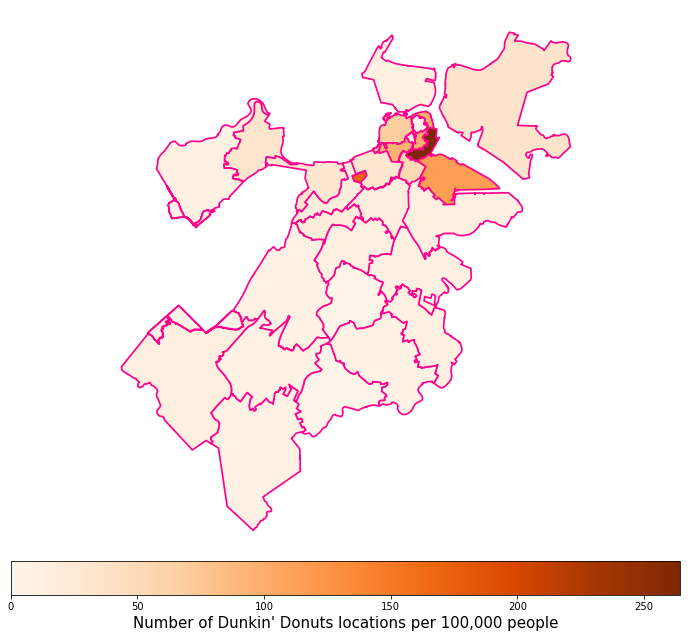

In [46]:
fig , ax = plt.subplots(figsize=(12, 12.0))

cmap = mpl.cm.get_cmap('Oranges')
norm = mpl.colors.Normalize(vmin = np.min(Boston_proper_ZipCode_geography_df.num_DD_locs_norm) , vmax = np.max(Boston_proper_ZipCode_geography_df.num_DD_locs_norm))

#plot Zip Codes 1-by-1
for zip_code , num_DD_locations_normalized in zip( Boston_proper_ZipCode_geography_df.ZIP5 , Boston_proper_ZipCode_geography_df.num_DD_locs_norm ):
    
    Boston_proper_ZipCode_geography_df[Boston_proper_ZipCode_geography_df.ZIP5 == zip_code].plot(ax = ax, color = cmap(norm(num_DD_locations_normalized)) , edgecolor = 'xkcd:hot pink' , linewidth = 1.7)
    
# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm = norm, cmap = cmap)
scalarmappaple.set_array(Boston_proper_ZipCode_geography_df.num_DD_locs_norm)
cbar = plt.colorbar(scalarmappaple , ax = ax , orientation = 'horizontal' , pad = 0.01)
cbar.set_label('Number of Dunkin\' Donuts locations per 100,000 people' , fontsize = 15)

plt.axis('off')
plt.show()

The winner is clearly 02110, which corresponds to Downtown Crossing, Financial District and the New England Aquarium! 

- There seems to be a few zip codes with a very high concentration of Dunkin' Donuts per capita, which makes it difficult to see how the other zip codes compare. So let's plot the heat map on a log scale.

- Using a log scale is pretty common in data visualization when there are a few outliers and makes it easier to compare observations between eachother, in this case the shades of zip codes that represent the Number of Dunkin' locations per 100,000 people.

- Log scaling shifts the observations (the colors) without changing the ordering of anything to make it easier to compare. Check out the scale bar before (above) and after (below) this transformation.

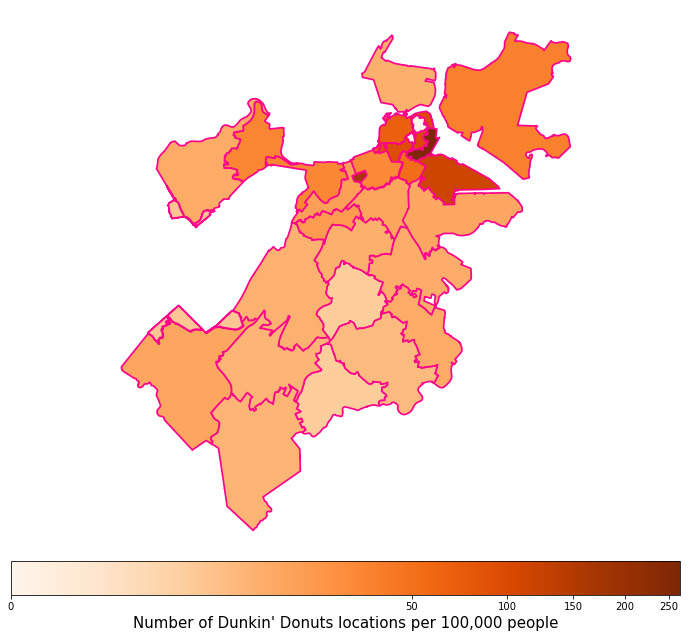

In [47]:
fig , ax = plt.subplots(figsize=(12, 12.0))

cmap = mpl.cm.get_cmap('Oranges')
norm = mpl.colors.PowerNorm(gamma=1.0/3.25 , vmin = np.min(Boston_proper_ZipCode_geography_df.num_DD_locs_norm) , vmax = np.max(Boston_proper_ZipCode_geography_df.num_DD_locs_norm))

#plot Zip Codes 1-by-1
for zip_code , num_DD_locations_normalized in zip( Boston_proper_ZipCode_geography_df.ZIP5 , Boston_proper_ZipCode_geography_df.num_DD_locs_norm ):
    
    Boston_proper_ZipCode_geography_df[Boston_proper_ZipCode_geography_df.ZIP5 == zip_code].plot(ax = ax, color = cmap(norm(num_DD_locations_normalized)) , edgecolor = 'xkcd:hot pink' , linewidth = 1.7)
    
# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm = norm, cmap = cmap)
scalarmappaple.set_array(Boston_proper_ZipCode_geography_df.num_DD_locs_norm)
cbar = plt.colorbar(scalarmappaple , ax = ax , orientation = 'horizontal' , pad = 0.01)
cbar.set_label('Number of Dunkin\' Donuts locations per 100,000 people' , fontsize = 15)

plt.axis('off')
plt.savefig('/home/rv76/RDMLA Course/Dunkin_density_in_Boston.eps', format='eps', dpi=1000)
plt.show()

Great! We've now answered the question that we sought out to answer AND we we create a cool visualization to display the results!

# [3.3] Heatmaps II - Algorithmic thinking when creating visualizations

When I finished making the heatmap above, I got an idea for another cool visualization from a friend.

Here's the idea:

- choose any point on the map and color it according to how close the nearest Dunkin' location is located.

A lot of the analysis and visualization above required knowledge and extensive use of packages in Python to filter points and plot them. But creating this visualization requires thinking outside the box a little more. When tasked with creating a visualization like this, it's important to sit down with a pencil and paper and start jotting down idea for how you could go about doing it. Step-by-step instructions for you could go about accomplishing the tast at hand, refining along the way.

Here's an outline for how we'll create this map:

1. We're going to create a rectangular grid of (lat/lng) POINTS that encompasses all of the Boston proper. In other words, we're going to find the lat/lng boundaries for the smallest rectangle that Boston fits within and then create a grid of POINT geometries within this rectanle.

1. We then take all of these points and filter out any POINT geometry that doesn't belong within one of the Boston zip codes. So we'll be left with a bunch of evenly spaced POINT geometries that reside within the bounds created by the Boston zip codes.

1. We have to write a function that takes as an *input* two lat/lng points and *returns* the distance between these point taking into account the curvature of Earth.

1. Then we will write another function that takes as an *input* some lat/lng POINT, calculates the distance between that POINT and the POINTS for all Dunkin' locations and *returns* (smallest distance or the distance to the nearest Dunkin').

1. Once we have that smallest distance for each evenly distributed POINT, we can create a heatmap like the one above. The big difference here will be that whereas before we colored the zip codes, now we're going to color each POINT in the map according to how close the nearest Dunkin' is located.



##### Heatmap of closest Dunkin' location

The epsg 3395 CRS worked well for visualizing the map, but now we'll want to start calculating distances between points so we're going to switch back to the epsg 4326 CRS to get back into the latitude and longitude coordinate system

In [48]:
crs = {'init':'epsg:4326'} #have to specify a coordinate reference system (this corresponds to the Mercator project system)

#DataFrame for zip codes
Boston_proper_ZipCode_geography_df = Boston_proper_ZipCode_geography_df.to_crs(crs)

#DataFrame for Dunkin' locations
Boston_proper_dunkin_donuts_locations_geography_df = Boston_proper_dunkin_donuts_locations_geography_df.to_crs(crs)

In [49]:
Boston_proper_ZipCode_geography_df.head()

,ZIP5,ShapeSTArea,ShapeSTLength,geometry,num_DD_locs,population,num_DD_locs_norm
OBJECTID,,,,,,,
1,02134,3.721936e+07,40794.182396,"POLYGON ((-71.12340461235523 42.3642086721427,...",6,18057,33.228111
2,02125,6.476052e+07,62224.521440,"POLYGON ((-71.04541458491363 42.3238066671522,...",4,35254,11.346230
3,02110,6.637284e+06,18358.213496,POLYGON ((-71.05109058896997 42.36418367507428...,6,2270,264.317181
4,02118,3.116158e+07,32353.407618,POLYGON ((-71.06315159137532 42.34688867055883...,4,27325,14.638609
5,02126,6.078585e+07,45488.394711,POLYGON ((-71.09669659978795 42.29095065982919...,1,29141,3.431591


In [50]:
Boston_proper_dunkin_donuts_locations_geography_df.head()

,id,address,city,state,zip,country,lat,lng,geometry
16,300240,13-15 Maverick Sq,East Boston,MA,2128,US,42.369062,-71.039333,POINT (-71.03933299999998 42.36906199999986)
51,300305,214 N. Beacon St,Brighton,MA,2135,US,42.356017,-71.149212,POINT (-71.14921199999999 42.35601699999987)
56,300314,875 Morrissey Blvd,Dorchester,MA,2122,US,42.293589,-71.048325,POINT (-71.04832500000001 42.29358899999986)
100,300417,715 Boylston St,Boston,MA,2116,US,42.349561,-71.079929,POINT (-71.07992899999999 42.34956099999987)
200,300660,4175 Washington St,Roslindale,MA,2131,US,42.287906,-71.126892,POINT (-71.12689199999998 42.28790599999987)


Now that we have our two important DataFrames, let's create a grid of lat/lon points residing within Boston.

We start this by finding the minimum & maximum **latitude** values (of all of Boston) by iterating over all of the zip code shapes

In [51]:
#default values for first zip code shape in df
min_lat_for_Boston = list( Boston_proper_ZipCode_geography_df.geometry )[0].bounds[1]
max_lat_for_Boston = list( Boston_proper_ZipCode_geography_df.geometry )[0].bounds[3]

for zip_code_i in Boston_proper_ZipCode_geography_df.index:
    
    #get the min, max latitude values for this zip code
    min_lat_for_zip , max_lat_for_zip = [ Boston_proper_ZipCode_geography_df.loc[zip_code_i , 'geometry'].bounds[1] , Boston_proper_ZipCode_geography_df.loc[zip_code_i , 'geometry'].bounds[3] ]
    
    #if smallest latitude value, store
    if min_lat_for_zip < min_lat_for_Boston:
        min_lat_for_Boston = min_lat_for_zip
    
    #if largest latitude value, store
    if max_lat_for_zip > max_lat_for_Boston:
        max_lat_for_Boston = max_lat_for_zip

In [52]:
print(min_lat_for_Boston , max_lat_for_Boston)

42.22787589864222 42.39644904958486


Let's find the minimum & maximum **longitude** values (of all of Boston) by iterating over all of the zip code shapes

In [53]:
#default values for first zip code shape in df
min_lng_for_Boston = list( Boston_proper_ZipCode_geography_df.geometry )[0].bounds[0]
max_lng_for_Boston = list( Boston_proper_ZipCode_geography_df.geometry )[0].bounds[2]

for zip_code_i in Boston_proper_ZipCode_geography_df.index:
    
    #get the min, max longitude values for this zip code
    min_lng_for_zip , max_lng_for_zip = [ Boston_proper_ZipCode_geography_df.loc[zip_code_i , 'geometry'].bounds[0] , Boston_proper_ZipCode_geography_df.loc[zip_code_i , 'geometry'].bounds[2] ]
    
    #if smallest longtidue value, store
    if min_lng_for_zip < min_lng_for_Boston:
        min_lng_for_Boston = min_lng_for_zip
    
    #if largest longitude value, store
    if max_lng_for_zip > max_lng_for_Boston:
        max_lng_for_Boston = max_lng_for_zip

In [54]:
print(min_lng_for_Boston , max_lng_for_Boston)

-71.19093112825009 -70.98607332666596


Create a **rectangular grid** of *POINTS* with the bounds above and load points into a new GeoPandas DataFrame.

In [55]:
#create a list of points across the grid that we'll turn into a geopandas dataframe later
Boston_grid_points = []

#store latitude & longitude values seperately for columns in dataframe
Boston_grid_points_lat = []
Boston_grid_points_lng = []

#Iterate through latitude values (step-wise) and find the corresponding evenly spaced longitude values within min/max range
## The smaller this value is, the greater the resolution will be in the visualization
interval_length = 0.00025

for lat_value in np.arange(min_lat_for_Boston , max_lat_for_Boston , interval_length):
    
    for lng_value in np.arange(min_lng_for_Boston , max_lng_for_Boston , interval_length):
        
        #create a Point with these coordinates and store in a list
        Boston_grid_points.append(Point(lng_value , lat_value))
        Boston_grid_points_lat.append(lat_value)
        Boston_grid_points_lng.append(lng_value)
        
#convert the list of points into a geopandas dataframe
Boston_grid_points_geography_df = gdp.GeoDataFrame(crs = {'init':'epsg:4326'} , geometry = Boston_grid_points)
Boston_grid_points_geography_df['latitude'] = Boston_grid_points_lat
Boston_grid_points_geography_df['longitude'] = Boston_grid_points_lng

In [56]:
Boston_grid_points_geography_df.head()

,geometry,latitude,longitude
0,POINT (-71.19093112825009 42.22787589864222),42.227876,-71.190931
1,POINT (-71.19068112825009 42.22787589864222),42.227876,-71.190681
2,POINT (-71.1904311282501 42.22787589864222),42.227876,-71.190431
3,POINT (-71.1901811282501 42.22787589864222),42.227876,-71.190181
4,POINT (-71.18993112825011 42.22787589864222),42.227876,-71.189931


In [57]:
np.shape(Boston_grid_points_geography_df) #553,500 lng/lat points make up a grid encasing all of the Boston zip codes

(553500, 3)

Boston isn't a rectangle, but the points in the DataFrame above make up a rectangular grid, so we should **throw out the points that aren't part of a boston zip code** to keep only those points that fall within one of the zip code shapes

In [58]:
#boolean for points to keep, True for rows we will keep, False for rows we will drop
Boston_grid_points_geography_df_filter = []

#iterate through all of the points and check to see if they belong to any of the zip codes
for Boston_grid_point_geo in  Boston_grid_points_geography_df.geometry:
    
    point_found = False
    #iterate through the zip codes and check to see if the point belongs to any zip code
    for Boston_zip_code_geo in Boston_proper_ZipCode_geography_df.geometry:
        
        #is the grid point part of this zip code?
        if Boston_zip_code_geo.contains(Boston_grid_point_geo):
            
            #point is contained within a zip code!
            point_found = True
            Boston_grid_points_geography_df_filter.append(True)
            
            #stop searching zip codes for this point, move onto next grid point
            break
            
        #keep searching
        else:
            pass
    
    #at the end of the loop, if the point hasn't been found in any zip codes, then append a False to the filter to drop this point
    if point_found == False:
        Boston_grid_points_geography_df_filter.append(False)
    
#subset grid points to those containe within Boston zip codes
Boston_grid_points_geography_df = Boston_grid_points_geography_df[Boston_grid_points_geography_df_filter]

In [59]:
np.shape(Boston_grid_points_geography_df) #only 224,107 points actually reside within (or on the border) of any of the zip codes of Boston proper

(224107, 3)

Create a **function** that finds the **distance between two points** on a map: point 1 (lat1, lng1) , point 2 (lat2 , lng2)

In [60]:
def haversine(lat1, lng1, lat2, lng2):
    
    'This function calculates the distance between 2 points using the Haversine forumula. (Taken from Stack Overflow, see references)'
    
    R = 6372.8 #this is in kilometers. For Earth radius in miles use 3959.87433 miles

    dLat = radians(lat2 - lat1)
    dLng = radians(lng2 - lng1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)

    a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLng/2)**2
    c = 2*asin(sqrt(a))

    return R * c

Create a **function** that takes a point from the Boston grid points and returns the **distance to the nearest Dunkin'**

In [61]:
def min_distance_to_Dunkin(point_lat , point_lng):
    
    'This function returns the minimum distance to any Dunkin location given a point in the Boston grid we defined'
    
    #list that stores the distance between a given point and all dunkin locations
    dist_to_all_Dunkin_locs = []

    #iterate through all Dunkin locations
    for Dunkin_loc_i_lat , Dunkin_loc_i_lng in zip( list(Boston_proper_dunkin_donuts_locations_geography_df.lat) , list(Boston_proper_dunkin_donuts_locations_geography_df.lng) ):

        #calculate distance
        dist_between_dunkin_i_and_grid_point = haversine(Boston_grid_point_lat, Boston_grid_point_lng, Dunkin_loc_i_lat, Dunkin_loc_i_lng)

        #store in list
        dist_to_all_Dunkin_locs.append(dist_between_dunkin_i_and_grid_point)

    #return the minimum distance to a Dunkin' location
    return min(dist_to_all_Dunkin_locs)

Call function above to get the **minimum distance to a Dunkin'** for all points in the Boston grid by iterating over all of the Boston POINT geometries

In [62]:
#list that stores the minimum distances for all points in the Geopandas DataFrame
min_distances_to_Dunkin = []

for Boston_grid_point_lat , Boston_grid_point_lng in zip( list(Boston_grid_points_geography_df.latitude) , list(Boston_grid_points_geography_df.longitude) ):
    
    min_distances_to_Dunkin.append(min_distance_to_Dunkin(Boston_grid_point_lat , Boston_grid_point_lng))
    
#store the minimum distances to DataFrame as a column
Boston_grid_points_geography_df['min_dist_to_Dunkin'] = min_distances_to_Dunkin

#create a column that's a repeat of the index to subset dataframe by
Boston_grid_points_geography_df['point_id'] = list(Boston_grid_points_geography_df.index)

In [63]:
Boston_grid_points_geography_df.head()

,geometry,latitude,longitude,min_dist_to_Dunkin,point_id
1060,POINT (-71.1309311282515 42.22812589864222),42.228126,-71.130931,1.089123,1060
1061,POINT (-71.13068112825151 42.22812589864222),42.228126,-71.130681,1.091171,1061
1878,POINT (-71.13143112825149 42.22837589864222),42.228376,-71.131431,1.058419,1878
1879,POINT (-71.1311811282515 42.22837589864222),42.228376,-71.131181,1.059727,1879
1880,POINT (-71.1309311282515 42.22837589864222),42.228376,-71.130931,1.061432,1880


We now have a DataFrame of a bunch of evenly spaced POINTS within Boston proper and the distance to the nearest Dunkin' location.

Quick question: If you're in Boston, how far are you away from a Dunkin' on average (in km)?

In [64]:
np.mean( Boston_grid_points_geography_df.min_dist_to_Dunkin )

0.6911226253851993

Now we'll create a column that stores the color for each point:
- *Lighter* colors correspond to a POINT on the map that's relatively close to a Dunkin' location
- *Darker* colors correspond to a POINT on the map that's further away from any Dunkin' locations.

In [65]:
cmap = mpl.cm.get_cmap('gist_yarg') #get matplotlib color map
norm = mpl.colors.PowerNorm(gamma=1.0/1.0 , vmin = np.min(Boston_grid_points_geography_df.min_dist_to_Dunkin) , vmax = np.max(Boston_grid_points_geography_df.min_dist_to_Dunkin))

#list that stores the color for each point in the Geopandas DataFrame, darker colors correspond to a shorter distance
min_dist_heatmap_color = []

for min_dist_to_Dunkin in list(Boston_grid_points_geography_df.min_dist_to_Dunkin):
    
    min_dist_heatmap_color.append( cmap(norm(min_dist_to_Dunkin)) )
    
#store the minimum distances to DataFrame as a column
Boston_grid_points_geography_df['heatmap_color'] = min_dist_heatmap_color

In [66]:
Boston_grid_points_geography_df.head()

,geometry,latitude,longitude,min_dist_to_Dunkin,point_id,heatmap_color
1060,POINT (-71.1309311282515 42.22812589864222),42.228126,-71.130931,1.089123,1060,"(0.5568627450980392, 0.5568627450980392, 0.556..."
1061,POINT (-71.13068112825151 42.22812589864222),42.228126,-71.130681,1.091171,1061,"(0.5529411764705883, 0.5529411764705883, 0.552..."
1878,POINT (-71.13143112825149 42.22837589864222),42.228376,-71.131431,1.058419,1878,"(0.5686274509803921, 0.5686274509803921, 0.568..."
1879,POINT (-71.1311811282515 42.22837589864222),42.228376,-71.131181,1.059727,1879,"(0.5686274509803921, 0.5686274509803921, 0.568..."
1880,POINT (-71.1309311282515 42.22837589864222),42.228376,-71.130931,1.061432,1880,"(0.5686274509803921, 0.5686274509803921, 0.568..."


Let's convert our Points to the Mercator projection format and our Zip Codes back to the Mercator projection format for better visulization

In [67]:
Boston_grid_points_geography_df = Boston_grid_points_geography_df.to_crs({'init':'epsg:3395'}) #the POINTS within Boston
Boston_proper_ZipCode_geography_df = Boston_proper_ZipCode_geography_df.to_crs({'init':'epsg:3395'}) #the zip code shape files if you also want to plot the boundaries of the zip code

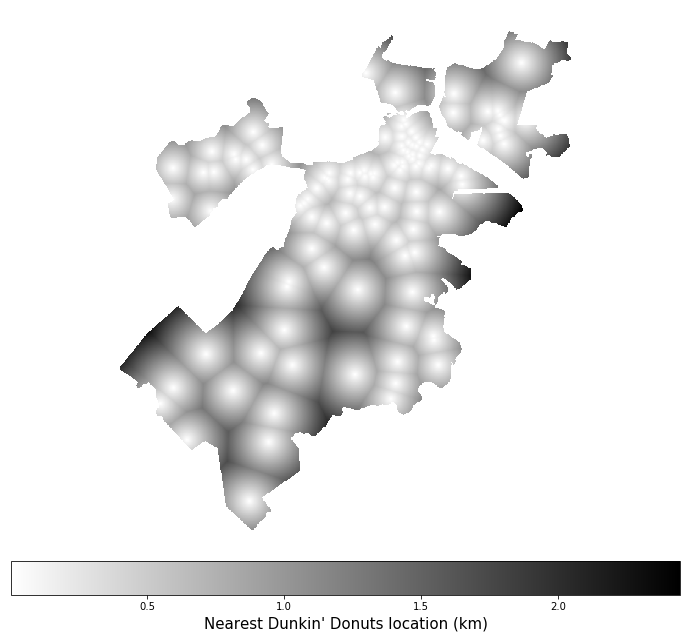

In [68]:
fig , ax = plt.subplots(figsize=(12, 12.0))

Boston_grid_points_geography_df.plot(ax = ax, color = list(Boston_grid_points_geography_df.heatmap_color) , markersize = 0.57 , marker = 's' , edgecolor = 'none')
#Boston_proper_ZipCode_geography_df.plot(ax = ax, color = 'None' ,  edgecolor = 'xkcd:neon green' , linewidth = 0.25 , alpha = 1.0) #uncomment this to get the zip code boundaries

# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm = norm, cmap = cmap)
scalarmappaple.set_array(Boston_grid_points_geography_df.min_dist_to_Dunkin)
cbar = plt.colorbar(scalarmappaple , ax = ax , orientation = 'horizontal' , pad = 0.01)
cbar.set_label('Nearest Dunkin\' Donuts location (km)' , fontsize = 15)

plt.axis('off')
plt.savefig('/home/rv76/RDMLA Course/nearest_Dunkin_in_Boston.eps', format='eps', dpi=1000)
plt.show()

We have the heatmap that we were after! I think it looks pretty cool and gives a nice visual of where the boundaries are that seperate one Dunkin' locations territory from the others.

If we scale the minimum distances according to a log scale and change the color map, we can reveal the locations of the Dunkin' themselves, coming full circle to where we started.

In [69]:
cmap = mpl.cm.get_cmap('seismic_r')
norm = mpl.colors.PowerNorm(gamma=1.0/3.5 , vmin = np.min(Boston_grid_points_geography_df.min_dist_to_Dunkin) , vmax = np.max(Boston_grid_points_geography_df.min_dist_to_Dunkin))

#list that stores the color for each point in the Geopandas DataFrame, darker colors correspond to a shorter distance
min_dist_heatmap_color = []

for min_dist_to_Dunkin in list(Boston_grid_points_geography_df.min_dist_to_Dunkin):
    
    min_dist_heatmap_color.append( cmap(norm(min_dist_to_Dunkin)) )
    
#store the minimum distances to DataFrame as a column
Boston_grid_points_geography_df['heatmap_color'] = min_dist_heatmap_color

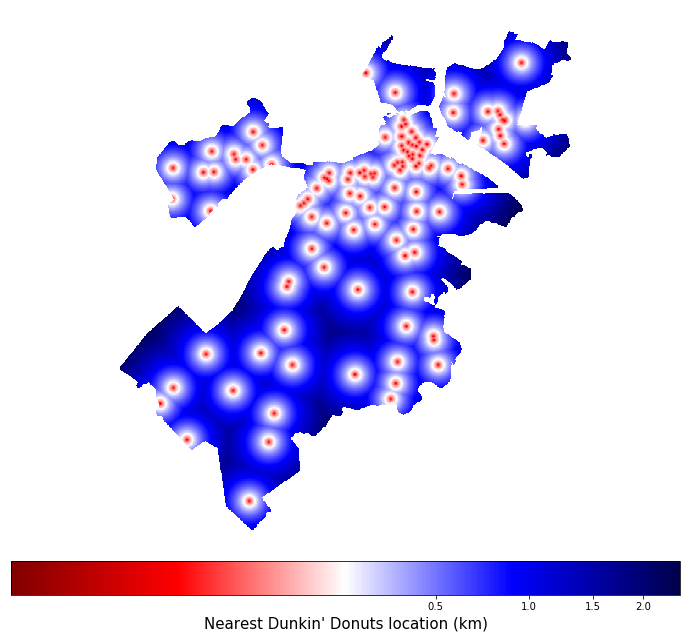

In [70]:
fig , ax = plt.subplots(figsize=(12, 12.0))

Boston_grid_points_geography_df.plot(ax = ax, color = list(Boston_grid_points_geography_df.heatmap_color) , markersize = 0.57 , marker = 's' , edgecolor = 'none')

# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm = norm, cmap = cmap)
scalarmappaple.set_array(Boston_grid_points_geography_df.min_dist_to_Dunkin)
cbar = plt.colorbar(scalarmappaple , ax = ax , orientation = 'horizontal' , pad = 0.01)
cbar.set_label('Nearest Dunkin\' Donuts location (km)' , fontsize = 15)

plt.axis('off')
#plt.savefig('/home/rv76/RDMLA Course/nearest_Dunkin_in_Boston_logscale.eps', format='eps', dpi=1000)
plt.show()

# [3.4] Testing for associations between variables

Often times in data analysis, you'll want to test for relationships between two variables. Know knowing what the concentration of Dunkin' locations was per each zip code in Boston, I wondered whether there was a relationship between this variable and the mean household income of each zip code.

- In other words, is there an association between the **Mean Household Income** and **Dunkin' locations per 100,000** individuals?

#### DD per 100,000 vs. Mean Household Income

In addition to giving use the population size of each zip code, the ACS also gives us the Mean income per zip code. So let's load that CSV file and clean it with Pandas to create a Series with mean income per zip code.

In [71]:
#load in CSV file that contains population estimate for each zip code in MA from the American Community Survey
MA_mean_income_per_zip_code_df = pd.read_csv('/home/rv76/RDMLA Course/Module 3 Files/MA_mean_income_per_zip_code.csv' , names = ['zip_code' , 'mean_income'] , header = 1)

#have to re-format zip code column
zip_codes = [zip_code.split(' ')[1] for zip_code in MA_mean_income_per_zip_code_df.zip_code]
MA_mean_income_per_zip_code_df['zip_code'] = zip_codes

#covert to a pandas series
MA_mean_income_per_zip_code = pd.Series(data = list(MA_mean_income_per_zip_code_df.mean_income) , index = MA_mean_income_per_zip_code_df.zip_code)

In [72]:
MA_mean_income_per_zip_code.head()

zip_code
01001     74096
01002     80304
01003         N
01005     95958
01007    104812
dtype: object

Now let's add the mean income of each Zip Code to our DataFrame with Boston Zip Codes.

In [73]:
#store the population estimate for each zip code in a list
mean_income_per_zip_code = []

#iterate through each Zip Code and get the population estimate from the MA zip code populatin estimates
for zip_code in Boston_proper_ZipCode_geography_df.ZIP5:
    
    #gets the mean income from pandas series with zip codes and population estimates
    mean_income_for_zip_code = MA_mean_income_per_zip_code[zip_code]
    
    #store in list
    mean_income_per_zip_code.append(mean_income_for_zip_code)
    
#append as an extra column to our Zip Code geography dataframe
Boston_proper_ZipCode_geography_df['mean_income'] = mean_income_per_zip_code

We now have a column with the mean household income in each zip code!

In [74]:
Boston_proper_ZipCode_geography_df.sort_values(by = 'mean_income' , ascending = False).head()

,ZIP5,ShapeSTArea,ShapeSTLength,geometry,num_DD_locs,population,num_DD_locs_norm,mean_income
OBJECTID,,,,,,,,
28,02203,8.644668e+05,4052.846084,POLYGON ((-7910159.366934435 5186603.184283855...,0,27,0.000000,N
25,02131,8.168880e+07,68311.545122,"POLYGON ((-7917402.48284091 5176915.856665359,...",3,32819,9.141046,91960
21,02136,1.281290e+08,65353.757829,POLYGON ((-7916591.158482961 5173714.965890127...,3,33084,9.067827,79517
14,02135,7.862083e+07,61170.630938,POLYGON ((-7917865.102197362 5188230.657026147...,5,42644,11.724979,79397
2,02125,6.476052e+07,62224.521440,POLYGON ((-7908739.374789597 5180829.878902349...,4,35254,11.346230,74396


Looks like we ran into a bit more noise: zip code 02203 (Boston City Hall, JFK Building, Government Center T & City Hall Plaza) has no mean income and even though this zip code has a recorded of 27 individuals from the ACS it might be an error and there may actually be 0 people residing in this zip code, so let's remove this from futher analysis.

In [75]:
Boston_proper_ZipCode_geography_df = Boston_proper_ZipCode_geography_df[Boston_proper_ZipCode_geography_df.ZIP5 != '02203']

Convert the mean income column to an *integer* type instead of a *string* type so we can analyze it.

In [76]:
Boston_proper_ZipCode_geography_df['mean_income'] = Boston_proper_ZipCode_geography_df['mean_income'].apply(pd.to_numeric)

In [77]:
Boston_proper_ZipCode_geography_df.head()

,ZIP5,ShapeSTArea,ShapeSTLength,geometry,num_DD_locs,population,num_DD_locs_norm,mean_income
OBJECTID,,,,,,,,
1,02134,3.721936e+07,40794.182396,"POLYGON ((-7917421.18493135 5186892.58815047, ...",6,18057,33.228111,69218
2,02125,6.476052e+07,62224.521440,POLYGON ((-7908739.374789597 5180829.878902349...,4,35254,11.346230,74396
3,02110,6.637284e+06,18358.213496,POLYGON ((-7909371.224670889 5186888.835886279...,6,2270,264.317181,256500
4,02118,3.116158e+07,32353.407618,POLYGON ((-7910713.849317108 5184293.074784191...,4,27325,14.638609,129325
5,02126,6.078585e+07,45488.394711,POLYGON ((-7914448.062572259 5175902.410114729...,1,29141,3.431591,66689


Our DataFrame that contains information for Boston zip codes now has columns for our two variables of interest:

1. number of Dunkin' locations per 100,000 people
1. mean income for each zip code

##### Run OLS Regression by Regressing *(DD locations per 100,000 people)* on *(Mean Income)*

Ordinary Least Squares (OLS) Regressions are commonly used in data analysis.

The basic idea is this: we're going to create a scatter plot where each point represents a zip code 
- x-value being the Mean Income
- y-value being the Dunkin' locations per 100,000 people

Then we're going to find the *line of best fit* through the data points, in other words the line that minimizes the distance between the line itself and all of the points in the scatter plot. 

I won't go into too many detail but if the points look like they more or less lie along the line, then the variables are said to be **associated** whereas if points appear to be plotted randomly and have little relationship with the line then there is probably no relationship/association between the two variables.

The block of code below performs the regression between the two variables and outputs the results.

In [78]:
#store the values in a dependent and independent vector 
Y = Boston_proper_ZipCode_geography_df.num_DD_locs_norm #vector of Dunkin' locations per 100,000 people per zip code
X = Boston_proper_ZipCode_geography_df.mean_income #vector of mean income per zip code
X = sm.add_constant(X)

#run the OLS with statsmodels
model = sm.OLS(Y , X)
results = model.fit()

#store the fitted parameters from the regression
constant_from_OLS = results.params[0]
coeff_from_OLS = results.params[1]

#create a vector for the line using the output parameters from the OLS regression
X_values_line_best_fit = np.arange( min(Boston_proper_ZipCode_geography_df.mean_income) , max(Boston_proper_ZipCode_geography_df.mean_income) , 1)
Y_values_line_best_fit = coeff_from_OLS * X_values_line_best_fit + constant_from_OLS

In [79]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       num_DD_locs_norm   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     11.47
Date:                Sun, 19 May 2019   Prob (F-statistic):            0.00184
Time:                        13:57:27   Log-Likelihood:                -184.30
No. Observations:                  35   AIC:                             372.6
Df Residuals:                      33   BIC:                             375.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -27.6037     20.053     -1.377      0.178     -68.401      13.194
mean_income     0.0005      0.000      3.387      0.002       0.000       0.001
==============================================================================
Omnibus:                       18.258   Durbin-Watson:                   1.534
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.070
Skew:                           1.378   Prob(JB):                     2.18e-06
Kurtosis:                       6.206   Cond. No.                     3.42e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.42e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Coefficient of DD locations per 100,000 regressed on Mean Income

- This quantifies the relationship between the two variables (also the slope of the line below). In general for every *\$1 increase* in **Mean Income** there is an *increase in 0.0004887* **Dunkin' locations per 100,000 people**. 

It's a bit wonky thinking in these decimals for Dunkin' locations, but essentially the takeaway is that if we increase the **Mean Income** in a given zip code by enough $$$, we should expect to see another **Dunkin' location in that zip code as long as the population doesn't change**.

In [80]:
results.params[1]

0.0004886600397916779

p-value for coefficient

- This tells use that there is a pretty strong linear association between these two variables and that the linear pattern that the points appear to follow was likely not due to chance (usually we look for a p-value < 0.05).

In [81]:
results.pvalues[1]

0.0018439678630164536

##### Plot results of regression

We can plot the results of the regression by plotting the two vectors of **Mean Income** and **Dunkin' locations per 100,000** for each zip code as points in an xy-plane. Then plotting the line of best fit through these points (from the OLS regression).

In [82]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=0
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=False
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 14})

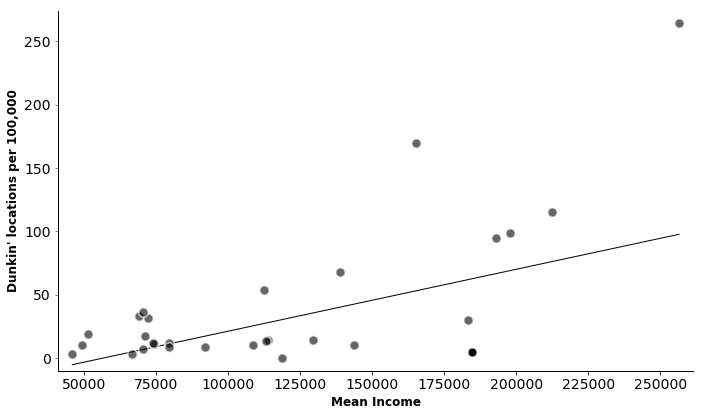

In [83]:
fig , ax = plt.subplots()

plt.scatter( Boston_proper_ZipCode_geography_df.mean_income , Boston_proper_ZipCode_geography_df.num_DD_locs_norm , color = '0.0' , edgecolor = 'white' , linewidth = 1.75 , alpha = 0.6 , s = 90)

#plot Line of Best Fit from OLS regression
plt.plot(X_values_line_best_fit , Y_values_line_best_fit , color = '0.0' , linestyle = '-' , linewidth = 1.0 , zorder=0 , alpha = 1.0)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(labelcolor = 'k')
ax.set_ylim([min( Boston_proper_ZipCode_geography_df.num_DD_locs_norm ) - 10 , max( Boston_proper_ZipCode_geography_df.num_DD_locs_norm ) + 10])
ax.set_xlim([min( Boston_proper_ZipCode_geography_df.mean_income ) - 5000 , max( Boston_proper_ZipCode_geography_df.mean_income ) + 5000])
plt.ylabel('Dunkin\' locations per 100,000' , fontweight = 'bold', fontsize = 12 , color = 'k')
plt.xlabel('Mean Income' , fontweight = 'bold', fontsize = 12 , color = 'k')

fig = plt.gcf()
fig.set_size_inches(10.0, 6.0)
fig.tight_layout()

#plt.show()

##### Correlation vs. Causation

You can see that there appears to be a positive relationship between the two variables! As **Mean Income** goes up, so does the **Dunkin' locations per 100,000 people**. We'll leave it as an exercise for you to think about why this might be the case.

However I'll just mention 1 important caveat to all of this! What we tested for was an **association** or a **correlation** between these variables, just because we found these variable to be correlated **does not imply causation**. 

Let me repeat this: **correlation does not imply causation**.

There could be a number of reasons why **Mean Income** and **Dunkin' locations per 100,000 people** are related like this and it's not immediately obvious that increasing the **Mean Income** in a zip code would drive an increase in **Dunkin' locations** in that zip code (or the other way around). There may be another **ommitted** variable that is driving the relationship here and when preforming any data analysis it's important to think about any limitations to what data you have and how you're analyzing it.

# References

**Dunkin' Donuts Location Data**

- [https://github.com/trendct/dunkin-donuts-ct](https://github.com/trendct/dunkin-donuts-ct)

**Zip Code Data**

- [https://data.boston.gov/dataset/zip-codes1](https://data.boston.gov/dataset/zip-codes1)

**Projections,Plotting in Geopandas & the Haversize Function**

- [https://automating-gis-processes.github.io/2017/lessons/L2/projections.html](https://automating-gis-processes.github.io/2017/lessons/L2/projections.html)
- [https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972](https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972)
- [https://en.wikipedia.org/wiki/Haversine_formula](https://en.wikipedia.org/wiki/Haversine_formula)
- [https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points](https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points)

**Mean Income and Population Size per Zip Code**

- [https://factfinder.census.gov/faces/nav/jsf/pages/index.xhtml](https://factfinder.census.gov/faces/nav/jsf/pages/index.xhtml)